# Initializing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import comet_ml
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_unet
from src.utils.train import unet_training_testing_loop
from src.utils.comet import CometLogger
from dotenv import load_dotenv

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

# for reproducibility
torch.manual_seed(SEED)

# Datasets

## COCO Datasets

In [3]:
slide_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/slides/l8/annotations.json")

In [4]:
import albumentations as A

transform = A.Compose([
    #A.HorizontalFlip(0.5),
    #A.VerticalFlip(0.5),
    A.ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))


/storage01/bolma/dev/tumor-region-detection-thesis/.venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/storage01/bolma/dev/tumor-region-detection-thesis/.venv/lib/python3.10/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [5]:
train_dataset = COCODataset(
    annotation_file=slide_path,
    train=True,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

test_dataset = COCODataset(
    annotation_file=slide_path,
    train=False,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 38 training images and 10 test images

✅ Loaded training set with 38 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 38 training images and 10 test images

✅ Loaded test set with 10 images

Training image id-s: 	{0, 1, 2, 3, 4, 6, 7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 47}

Test image id-s: 	{5, 37, 8, 9, 12, 46, 24, 25, 27, 30}

✅ Datasets are properly split and ready to use!


### Visualization

Training Dataset Examples:
Image index: 32 (Image ID: 41)


/storage01/bolma/dev/tumor-region-detection-thesis/src/utils/coco.py:211: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  target["masks"] = torch.as_tensor(masks, dtype=torch.uint8)


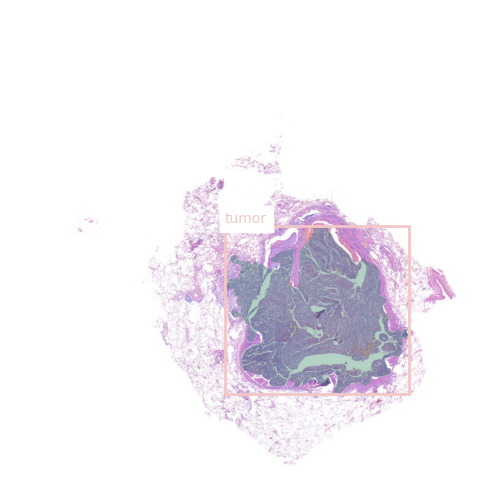

Image index: 37 (Image ID: 47)


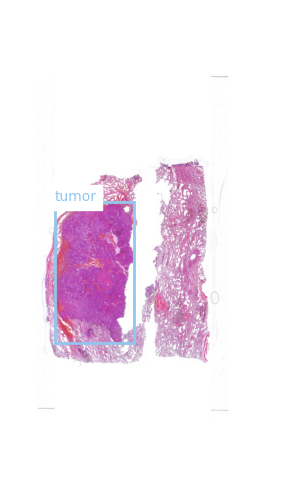

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.patches import Rectangle

def visualize_coco_samples(dataset, num_samples=3, indices=None, figsize=(15, 5), 
                          show_masks=True, show_boxes=True, show_labels=True,
                          mask_alpha=0.3, random_color=True):
    """
    Visualizes samples from COCO dataset with annotations.
    """
    if indices is None:
        # Get random indices
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in indices:
        print(f"Image index: {idx} (Image ID: {dataset.image_ids[idx]})")
        image, target = dataset[idx]
        
        # If image is a tensor, convert to numpy array for visualization
        if isinstance(image, torch.Tensor):
            img = image.cpu().numpy().transpose(1, 2, 0)
            # Use consistent scaling - divide by 255 instead of min-max normalization
            img = img / 255.0
            # Clip to valid range
            img = np.clip(img, 0, 1)
        else:
            img = np.array(image) / 255.0
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=figsize)
        
        # Display image
        ax.imshow(img)
        
        # Get masks, boxes, and labels from target
        masks = target['masks']
        boxes = target['boxes']
        labels = target['labels']
        
        # Create a single combined overlay for all masks
        if show_masks and len(masks) > 0:
            # Initialize combined overlay
            h, w = masks[0].shape if len(masks) > 0 else img.shape[:2]
            combined_overlay = np.zeros((h, w, 4))  # RGBA image for overlay
            
            for i in range(len(masks)):
                if i < len(masks):
                    # Generate color for this instance
                    if random_color:
                        color = np.random.rand(3)
                    else:
                        cmap = plt.cm.get_cmap('tab10')
                        color = cmap(labels[i] % 10)[:3]
                    
                    # Add this mask to the combined overlay
                    mask = masks[i].cpu().numpy()
                    combined_overlay[mask == 1, :3] = color
                    combined_overlay[mask == 1, 3] = mask_alpha  # Set alpha channel
            
            # Apply the combined overlay
            ax.imshow(combined_overlay)
        
        # Display bounding boxes and labels
        for i in range(len(boxes)):
            # Generate color for this instance
            if random_color:
                color = np.random.rand(3)
            else:
                cmap = plt.cm.get_cmap('tab10')
                color = cmap(labels[i] % 10)[:3]
            
            # Display bounding box if requested
            if show_boxes and i < len(boxes):
                box = boxes[i].cpu().numpy()
                x1, y1, x2, y2 = box
                width = x2 - x1
                height = y2 - y1
                rect = Rectangle((x1, y1), width, height, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Display category label if requested
                if show_labels:
                    category_id = labels[i].item()
                    category_name = dataset.categories.get(category_id, str(category_id))
                    ax.text(x1, y1-5, category_name, color=color, 
                           fontsize=10, backgroundcolor='white')
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

print("Training Dataset Examples:")
visualize_coco_samples(train_dataset, num_samples=2)

## Dataloaders

In [7]:
BATCH_SIZE = 1
NUM_WORKERS = 8

In [8]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


ℹ️ Created DataLoaders with batch size 1
	- Training batches: 38
	- Test batches: 10


# Training

## Model architecture

In [9]:
unet = get_model_unet(in_channels=3,
                          out_channels=1,
                          features=[32, 64, 128, 256])

optimizer = torch.optim.SGD(unet.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)

## Training loop

In [11]:
import warnings

# For logging to comet.ml, a cloud service
load_dotenv()
api_key = os.getenv('COMET_API_KEY')
comet_logger = CometLogger(api_key=api_key,
                        project_name="msc-thesis",
                        experiment_name="UNet-valid",
                        log_env_details=False,)

# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    # Training loop
    unet_training_testing_loop(unet, device, train_dataloader, test_dataloader, optimizer, scheduler, n_epochs=30, comet_logger=comet_logger)

comet_logger.end() # End the comet logger session

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet-valid
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/1b6b12826a9f403eb1e8acfe27787d3d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou [20]           : (0.4221701890230179, 0.6310760766267777)
COMET INFO:     learning_rate      : 0.01
COMET INFO:     loss [78]          : (0.5863784551620483, 0.9388275146484375)
COMET INFO:     test_loss [20]     : (0.6708238184452057, 0.7620068728923798)
COMET INFO:     training_loss [20] : (0.6647632718086243, 0.8219718337059021)
COMET INFO:   Others:
COMET INFO:     Name : UNet-valid
COMET INFO:   Uploads:
COMET INFO:     filename                 : 1
COMET IN

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/bolf-marton/msc-thesis/27b96a793f5c4890922b3ed283bf96bd




🚀 STARTING TRAINING
-----------------------
Epoch 1/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:03<00:00,  9.74it/s]


Train – Mean Loss: 0.6656


100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


Test – IoU: 0.5837, Loss: 0.6733
-----------------------
Epoch 2/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:04<00:00,  9.47it/s]


Train – Mean Loss: 0.6639


100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


Test – IoU: 0.6254, Loss: 0.6684
-----------------------
Epoch 3/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:03<00:00,  9.64it/s]


Train – Mean Loss: 0.6620


100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


Test – IoU: 0.6358, Loss: 0.6689
-----------------------
Epoch 4/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:03<00:00, 10.12it/s]


Train – Mean Loss: 0.6622


100%|██████████| 10/10 [00:01<00:00,  9.08it/s]


Test – IoU: 0.5744, Loss: 0.6692
-----------------------
Epoch 5/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:04<00:00,  8.71it/s]


Train – Mean Loss: 0.6624


100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


Test – IoU: 0.5865, Loss: 0.6723
-----------------------
Epoch 6/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:04<00:00,  9.32it/s]


Train – Mean Loss: 0.6618


100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Test – IoU: 0.5303, Loss: 0.6799
-----------------------
Epoch 7/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:04<00:00,  8.91it/s]


Train – Mean Loss: 0.6623


100%|██████████| 10/10 [00:01<00:00,  9.02it/s]


Test – IoU: 0.6014, Loss: 0.6683
-----------------------
Epoch 8/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:04<00:00,  8.46it/s]


Train – Mean Loss: 0.6610


100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


Test – IoU: 0.6302, Loss: 0.6766
-----------------------
Epoch 9/30 - UNet-valid
-----------------------


100%|██████████| 38/38 [00:04<00:00,  9.46it/s]


Train – Mean Loss: 0.6612


100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


Test – IoU: 0.4999, Loss: 0.6734
------------------------
Epoch 10/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.82it/s]


Train – Mean Loss: 0.6625


100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


Test – IoU: 0.5145, Loss: 0.6742
------------------------
Epoch 11/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.56it/s]


Train – Mean Loss: 0.6604


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Test – IoU: 0.4704, Loss: 0.6737
------------------------
Epoch 12/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:03<00:00,  9.66it/s]


Train – Mean Loss: 0.6589


100%|██████████| 10/10 [00:01<00:00,  9.03it/s]


Test – IoU: 0.6024, Loss: 0.6703
------------------------
Epoch 13/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.90it/s]


Train – Mean Loss: 0.6586


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


Test – IoU: 0.6213, Loss: 0.6670
------------------------
Epoch 14/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  9.32it/s]


Train – Mean Loss: 0.6616


100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Test – IoU: 0.6556, Loss: 0.6724
------------------------
Epoch 15/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.75it/s]


Train – Mean Loss: 0.6599


100%|██████████| 10/10 [00:01<00:00,  8.98it/s]


Test – IoU: 0.5455, Loss: 0.6694
------------------------
Epoch 16/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:03<00:00,  9.65it/s]


Train – Mean Loss: 0.6589


100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


Test – IoU: 0.6481, Loss: 0.6751
------------------------
Epoch 17/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.09it/s]


Train – Mean Loss: 0.6578


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Test – IoU: 0.6256, Loss: 0.6783
------------------------
Epoch 18/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  9.42it/s]


Train – Mean Loss: 0.6575


100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Test – IoU: 0.6210, Loss: 0.6805
------------------------
Epoch 19/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.12it/s]


Train – Mean Loss: 0.6580


100%|██████████| 10/10 [00:01<00:00,  9.12it/s]


Test – IoU: 0.2277, Loss: 0.6776
------------------------
Epoch 20/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.92it/s]


Train – Mean Loss: 0.6574


100%|██████████| 10/10 [00:01<00:00,  9.09it/s]


Test – IoU: 0.6389, Loss: 0.6703
------------------------
Epoch 21/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  9.12it/s]


Train – Mean Loss: 0.6562


100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


Test – IoU: 0.6371, Loss: 0.6696
------------------------
Epoch 22/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:03<00:00,  9.89it/s]


Train – Mean Loss: 0.6569


100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


Test – IoU: 0.4010, Loss: 0.6717
------------------------
Epoch 23/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.29it/s]


Train – Mean Loss: 0.6554


100%|██████████| 10/10 [00:01<00:00,  8.93it/s]


Test – IoU: 0.6047, Loss: 0.6865
------------------------
Epoch 24/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  9.49it/s]


Train – Mean Loss: 0.6542


100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Test – IoU: 0.6300, Loss: 0.6702
------------------------
Epoch 25/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.83it/s]


Train – Mean Loss: 0.6538


100%|██████████| 10/10 [00:01<00:00,  8.82it/s]


Test – IoU: 0.6123, Loss: 0.6734
------------------------
Epoch 26/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.66it/s]


Train – Mean Loss: 0.6530


100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Test – IoU: 0.6332, Loss: 0.6710
------------------------
Epoch 27/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:03<00:00, 10.20it/s]


Train – Mean Loss: 0.6525


100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


Test – IoU: 0.6105, Loss: 0.6699
------------------------
Epoch 28/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  8.57it/s]


Train – Mean Loss: 0.6524


100%|██████████| 10/10 [00:01<00:00,  9.07it/s]


Test – IoU: 0.6195, Loss: 0.6698
------------------------
Epoch 29/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  9.40it/s]


Train – Mean Loss: 0.6523


100%|██████████| 10/10 [00:01<00:00,  8.92it/s]


Test – IoU: 0.6303, Loss: 0.6722
------------------------
Epoch 30/30 - UNet-valid
------------------------


100%|██████████| 38/38 [00:04<00:00,  9.49it/s]


Train – Mean Loss: 0.6522


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : UNet-valid
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/27b96a793f5c4890922b3ed283bf96bd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou [30]           : (0.22768802378050168, 0.6555806651711464)
COMET INFO:     learning_rate [30] : (0.001, 0.01)
COMET INFO:     loss [114]         : (0.56500643491745, 0.7263721227645874)
COMET INFO:     test_loss [30]     : (0.6670373678207397, 0.6864580154418946)
COMET INFO:     training_loss [30] : (0.652234673500061, 0.6656191945075989)
COMET INFO:   Others:
COMET INFO:     Name : UNet-valid
COMET INFO:   Uploads

Test – IoU: 0.6277, Loss: 0.6727


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 24 metrics, params and output messages


In [ ]:
# Save the model weights
torch.save(unet.state_dict(), "src/models/weights/UNet_trained_weights_eval.pth")